# Simulation Study for Goodness-of-Fit Tests via Persistence Diagrams

In this notebook, we illustrate how to devise goodness-of-fit tests for point patterns based on statistics derived from the persistence diagram. In a first step, this concerns deviation tests based on scalar quantities that are asymptotically normal. In the second step, the persistence diagram serves as functional summary statistic for a global envelope test.

In [6]:
rm(list = ls())
library(GET)
library(ggplot2)
library(grid)
library(gridExtra)
library(parallel)
library(reshape)
library(spatstat)
library(TDA)

Loading required package: spatstat.data

Loading required package: nlme

Loading required package: rpart


spatstat 1.62-2       (nickname: ‘Shape-shifting lizard’) 
For an introduction to spatstat, type ‘beginner’ 




For the entire simulation study, the null model is a homogeneous Poisson point process with intensity $2$ in a $10 \times 10$ observation window. 

In [7]:
win = owin(c(0,10), c(0,10))

## Deviation Test for Complete Spatial Randomness

As a first step, we apply the central limit theorem of the persistence diagram in large domains to derive a deviation test against complete spatial randomness via two TDA-based summary statistics. 

As a test statistic based on clusters, we use the integral over the number of cluster deaths in a finite time interval $[0, r_{\mathsf c}]$ with $r_{\mathsf c} \le r_{\mathsf f}$, i.e.,
$$\int_0^{r_{\mathsf c}} \mathsf{PD}^0(\mathcal P_n)([0, d]) {\rm d}d.$$
After subtracting the mean, this test statistic becomes reminiscent of the classical Cram\'er-von-Mises statistic except that we do not consider squared deviations. Although squaring would make it easier to detect two-sided deviations, it would also require knowledge of quantiles of the square integral of a centered Gaussian process. Albeit possible, this incurs substantial computational expenses.  Hence, our simpler alternative has the appeal that as an integral of a Gaussian process, the test statisticis asymptotically normal and therefore characterized by its mean and variance.


However, this statistic requires that the intensity is known in advance, whereas in practice we need to estimate it from data. To arrive at an intensity-adapted version, we know that for every $a > 0$,
$$\mathsf{PD}^0((a\mathcal P)_{an})([0, ad]) = \mathsf{PD}^0( \mathcal P_n)([0, d]).$$
Moreover, if $\mathcal P$ is a Poisson point process with intensity $\lambda_0$, then the scaled process $a\mathcal P$ is a Poisson point process with intensity $a^{-2}\lambda_0$. Noting that also the Lebesgue integral produces a factor $a$ through a change of variable, we arrive at the test statistc

Hence, after taking these scalings into account, we obtain the intensity-dependent test statistic:
\begin{align}
        \label{t0Def}
        T_{\mathsf C} = \frac1{\sqrt{\lambda}|W|}\int_0^{r_{\mathsf C} / \sqrt\lambda} \mathsf{PD}^0(\mathcal P_n)([0, d]) {\rm d}d.
\end{align}

To compute the persistence diagram, we rely on the package [TDA](https://cran.r-project.org/web/packages/TDA/index.html).

In [8]:
t_vals0 <- seq(0, .299, by = 1e-3)

tda0_raw <- function(coords){
    #' Death times of a point pattern
    #'
    #' @param coords coordinates of point pattern
    
    diag <- alphaComplexDiag(coords)$diagram
    diag_df <-  data.frame(dimension = diag[,1], 
                           death = diag[,3])
    sort(diag_df[diag_df$dimension == 0, 'death'])  
}

tda0 <- function(X, 
                 r = 0, 
                 tx = t_vals0,
                 correction = NULL){
    #' Adapter of death times for spatstat scaled by number of points
    #'
    #' @param X point pattern
    #' @param r time point
    #' @param t_vals time values for which the accumulated death count is computed
    #' @param correction edge correction
    dt <- tda0_raw(cbind(X$x, X$y))
    
    #intensity 
    intens <- X$n / area.owin(win)
    
    #rescale integration domain
    tx <- tx * sqrt(2 / intens)
    
    fv(data.frame(r = tx, 
                  trans = findInterval(tx, dt) / (sqrt(intens) * area.owin(win))), 
       valu = 'trans',
       labl = c('r', 'lab'),
       fname='Diag')
}

As a test statistic based on loops, we use the accumulated persistence function, which aggregates the life times of all loops with birth times in a time interval $[0, r_{\mathsf L}]$ with $r_{\mathsf L} \le r_{\mathsf f}$. That is,
$$\int_{[0, r_{\mathsf L}] \times [0, r_{\mathsf f}]} (d - b) \mathsf{PD}^1(\mathcal P_n)({\rm d}b, {\rm d}d).$$
After centering and rescaling, this statisitc converges in the large-volume limit to a normal random variable.
As in the cluster-based test, we adapt to the intensity, to obtain
\begin{align}
        \label{t1Def}
        T_{\mathsf L} =  \frac1{\sqrt{\lambda}|W|}\int_{\big[0, r_{\mathsf L} / \sqrt \lambda\big] \times \big[0, r_{\mathsf f} / \sqrt \lambda\big]} (d - b) \mathsf{PD}^1(\mathcal P_n)({\rm d}b, {\rm d}d)
\end{align}

The statistics $T_{\mathsf C}$ and $T_{\mathsf L}$ are specific possibilities to define scalar characteristics from the persistence diagram. Depending on the application context other choices, such as $\mathsf{APF}^0$ instead of $T_{\mathsf C}$ could be useful. However, in the simulation study below, we found the weighting by life times of clusters to be detrimental.

In [9]:
t_vals1 <- seq(0, .499, by=5e-3)
ty1 <- seq(0, .299, by=1e-2)

tda1_raw <- function(coords,
                     max_bt = 10){
    #' accumulated persistence function of a point pattern
    #'
    #' @param coords coordinates of point pattern
    #' @param max_bt add maximum birth time to avoid out of bound error
    
    diag <- alphaComplexDiag(coords)$diagram
    diag_df <- data.frame(dimension = diag[,1], 
                           birth = diag[,2], 
                           life = (diag[,3] - diag[,2]))
    
    #only 1-dimensional features
    diag_df <- diag_df[diag_df$dimension == 1, 2:3]
    diag_df <- diag_df[order(diag_df$birth),]
    rownames(diag_df) <- c()
    rbind(diag_df, c(max_bt, max_bt))
}

tda1 <- function(X, 
                 r = 0, 
                 tx = t_vals1,
                 correction = NULL){
    #' Adapter of the accumulated persistence function for spatstat
    #'
    #' @param X point pattern
    #' @param r time point
    #' @param tx times at which the APF is computed
    
    tda1_vals <- tda1_raw(cbind(X$x, X$y))
    tda1_vals <- cbind(tda1_vals[,1], cumsum(tda1_vals$life))  
    birth_locs = findInterval(tx, tda1_vals[,1])
    
    #intensity 
    intens <- X$n / area.owin(win)
    
    #rescale integration domain
    tx <- tx * sqrt(2 / intens)
    
    fv(data.frame(r = tx, 
                  trans = tda1_vals[1 + birth_locs, 2] / (sqrt(intens) * area.owin(win))), 
      valu = 'trans',
      labl = c('r', 'lab'),
      fname='Diag')
}

Finally, we compare the TDA-based statistics to a quantity derived from the classical Ripley L-function. More precisely, we let 
$$T_{\mathsf {Rip}} = \int_0^{r_{\mathsf {Rip}}} \hat L(r){\rm d}r$$
denote the integral of the estimated Ripley's L-function until a radius $r_{\mathsf{Rip}} > 0$. We note that there is no need for a normalization as estimating the L-function already takes into account an estimated intensity. By existing [FCLTs for Ripley's K-function](https://link.springer.com/article/10.1007/s10986-015-9266-z), we expect that $T_{\mathsf{Rip}}$ is also asymptotically normal.

In [10]:
Lstat <- function(X, 
                  rmax = .5){
    #' Statistics based on Ripley's L-function.
    #'
    #' @param X point pattern
    #' @param rmax Maximum desired value of the radius
    L <- Lest(X,
              rmax = rmax)
    
    res <-fv(data.frame(r = L$r, 
                    trans = L$trans), 
       valu = 'trans',
       labl = c('r', 'lab'),
       fname='Diag')
}

### Exploratory Analysis

In the simulation study, we explore how reliably the cluster- and loop-based tests can detect deviations from the null model of complete spatial randomness. As alternatives to the null hypothesis, we consider Matérn cluster process as an example for an attractive point pattern. Then, we take the Strauss processes and the Ginibre point process as examples for repulsive point patterns. Finally, we take the Baddeley-Silverman process as a point process with complex higher-order interactions.
More precisely, the Matérn cluster process $\mathsf{MatC}(2, 0.5, 1)$ features a Poisson parent process with intensity 2 and generates a $\mathsf{Poi}(1)$ number of offspring uniformly in a disk of radius $0.1$ around each parent. The Strauss process $\mathsf{Str}(4.0, 0.6, 0.5)$ has interaction parameter $0.6$ and interaction radius $0.5$, respectively.

In [11]:
ginibre <- function(W = win,
                    n = 300,
                    offset = 17.75,
                    bbox = 1000
                   ){
    #' Ginibre point process in a window
    #'
    #' @param W sampling window
    #' @param n number of points in larger window
    #' @param offset offset for plus sampling 
    #' @param bbox bounding box size
    
    #find eigenvalues of random matrix
    ginibs <- matrix(rnorm(n * n) + rnorm(n * n) * 1i, 
                      ncol = n)
    evs <- eigen(ginibs)$values
    
    #shift and scale points to window size
    evs_shift <- evs + (offset + offset * 1i)
    evs_scaled <- evs_shift * (W$xrange)[2] / (2. * offset) 
    
    #restrict to sampling window
    X <- ppp(x = Re(evs_scaled), 
             y = Im(evs_scaled),
             window = owin(c(-bbox, bbox), 
                           c(-bbox, bbox)))
    X[W]    
}

In [12]:
seed <- 45
set.seed(seed)
nsim <- 1e3

time <- Sys.time()

ppps_val <- rpoispp(2, 
                    win = win, 
                    nsim = nsim)

mcps <- rMatClust(2, .5, 1, 
                  win = win, 
                  nsim = nsim) 

strs <- rStrauss(4, .6, .5,  
                 W = win, 
                 nsim = nsim)

basi <- rcell(win, 
              dx = .67, 
              nsim = nsim)

ginibs <- mclapply(1:nsim,
                   function(i) ginibre(win),
                   mc.cores = 36)
Sys.time() - time 

Time difference of 3.621955 mins

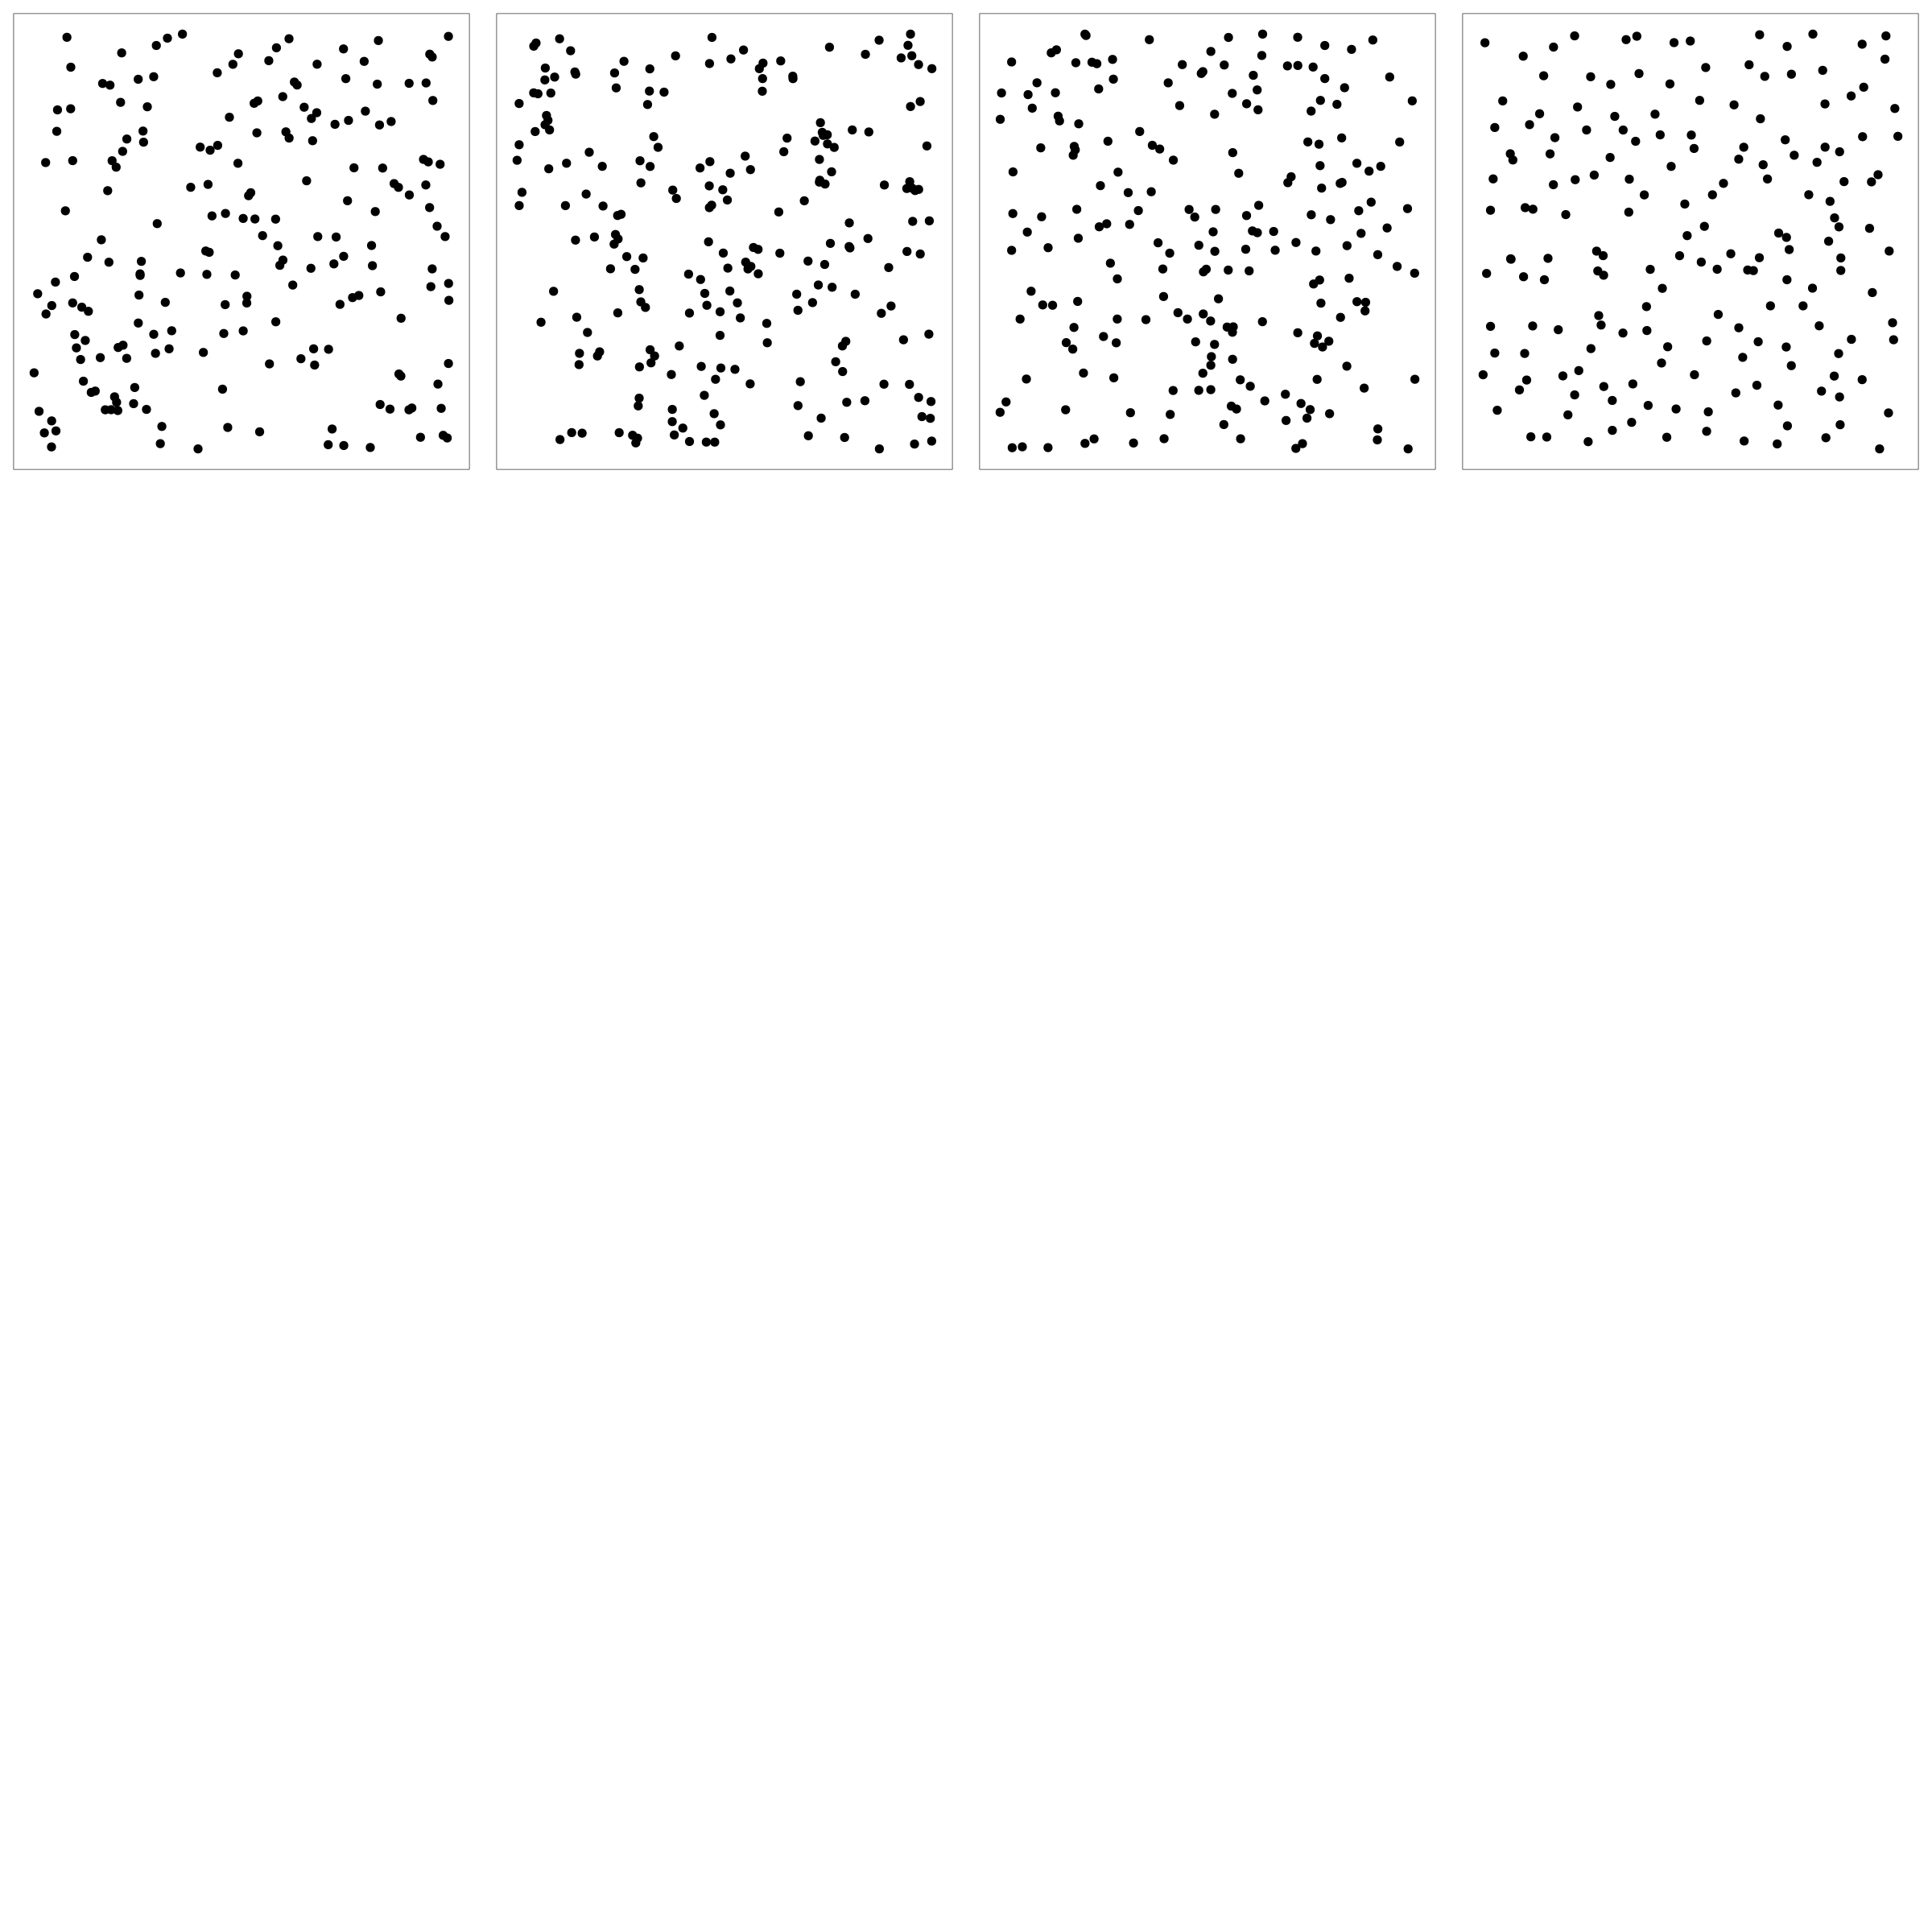

In [13]:
width = 20
height = 20
options(repr.plot.width = width, 
        repr.plot.height = height)

real <- 5

samples <-list(ppps_val[[real]], 
               mcps[[real]],  
               strs[[real]], 
               basi[[real]],
               ginibs[[real]])

plots <- lapply(samples, 
                function(pp) qplot(x = pp$x, 
                                   y = pp$y, 
                                   size = I(2.5)) + 
                    theme_void() +
                    theme(plot.margin = margin(10, 10, 10, 10)) +
                    theme(panel.border = element_rect(fill = NA)) 
                )
grid.arrange(plots[[1]], 
             plots[[2]], 
             plots[[3]], 
             plots[[4]],
             clip = F,
             nrow = 4, ncol = 4)

Next, we compare the persistence diagrams.

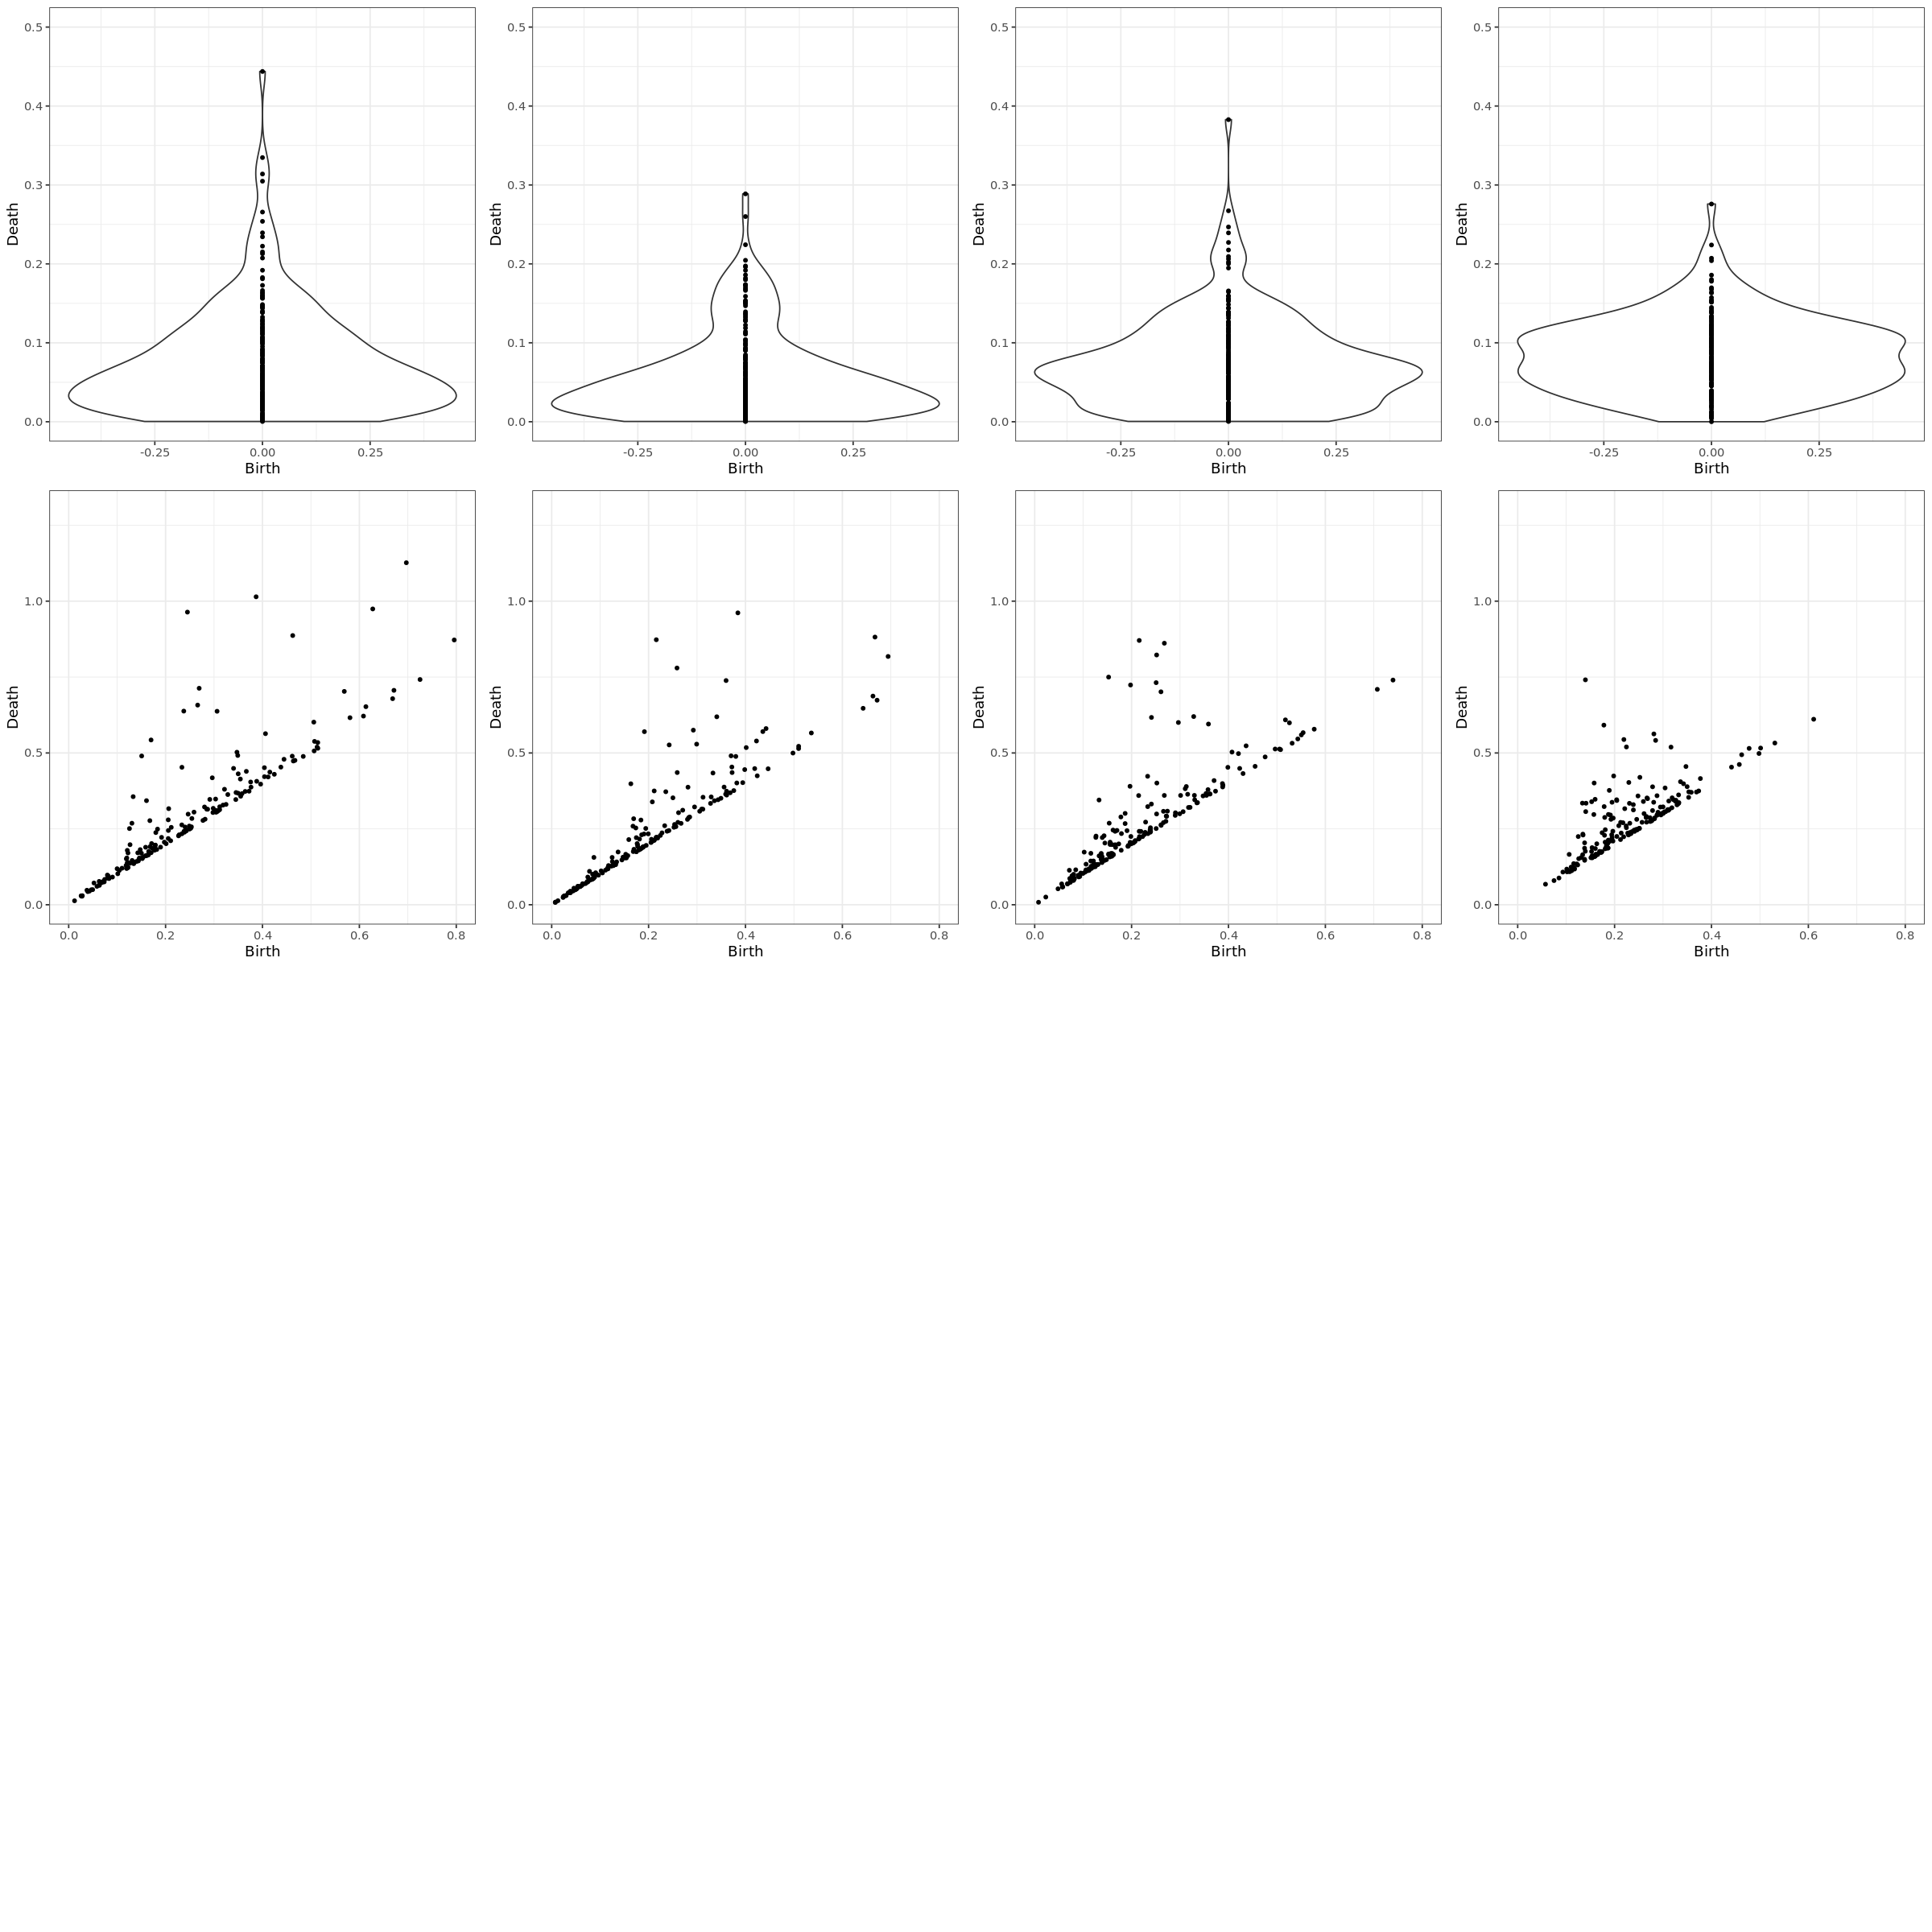

In [23]:
library(grid)

#0-features
plots0 <- lapply( samples,
                function(pp){
                    pd <- alphaComplexDiag(cbind(pp$x, pp$y))$diag
                            ggplot(data.frame(pd[pd[,'dimension'] == 0, 
                                                 2:3][-1,]), 
                            aes(x = Birth, y = Death)) +
                            geom_violin() +
                            geom_point(size = 1) +
                            scale_y_continuous(limits = c(0, 0.5)) +
                            theme_bw()                           
                    })

#1-features
plots1 <- lapply(samples,
                function(pp){
                    pd <- alphaComplexDiag(cbind(pp$x, pp$y))$diag
                            ggplot(data.frame(pd[pd[,'dimension'] == 1, 2:3]), 
                            aes(x = Birth, y = Death)) +
                            geom_point(size = 1) +
                            scale_x_continuous(limits = c(0, .8)) + 
                            scale_y_continuous(limits = c(0, 1.3)) +
                            theme_bw()
                    })

options(warn=-1)
grid.arrange(grobs = list(plots0[[1]], plots0[[2]], plots0[[3]],plots0[[4]],
                           plots1[[1]] ,plots1[[2]],plots1[[3]],plots1[[4]]),
            ncol = 4, nrow = 4)
options(warn=0)

Finally, we illustrate the corresponding L-functions.

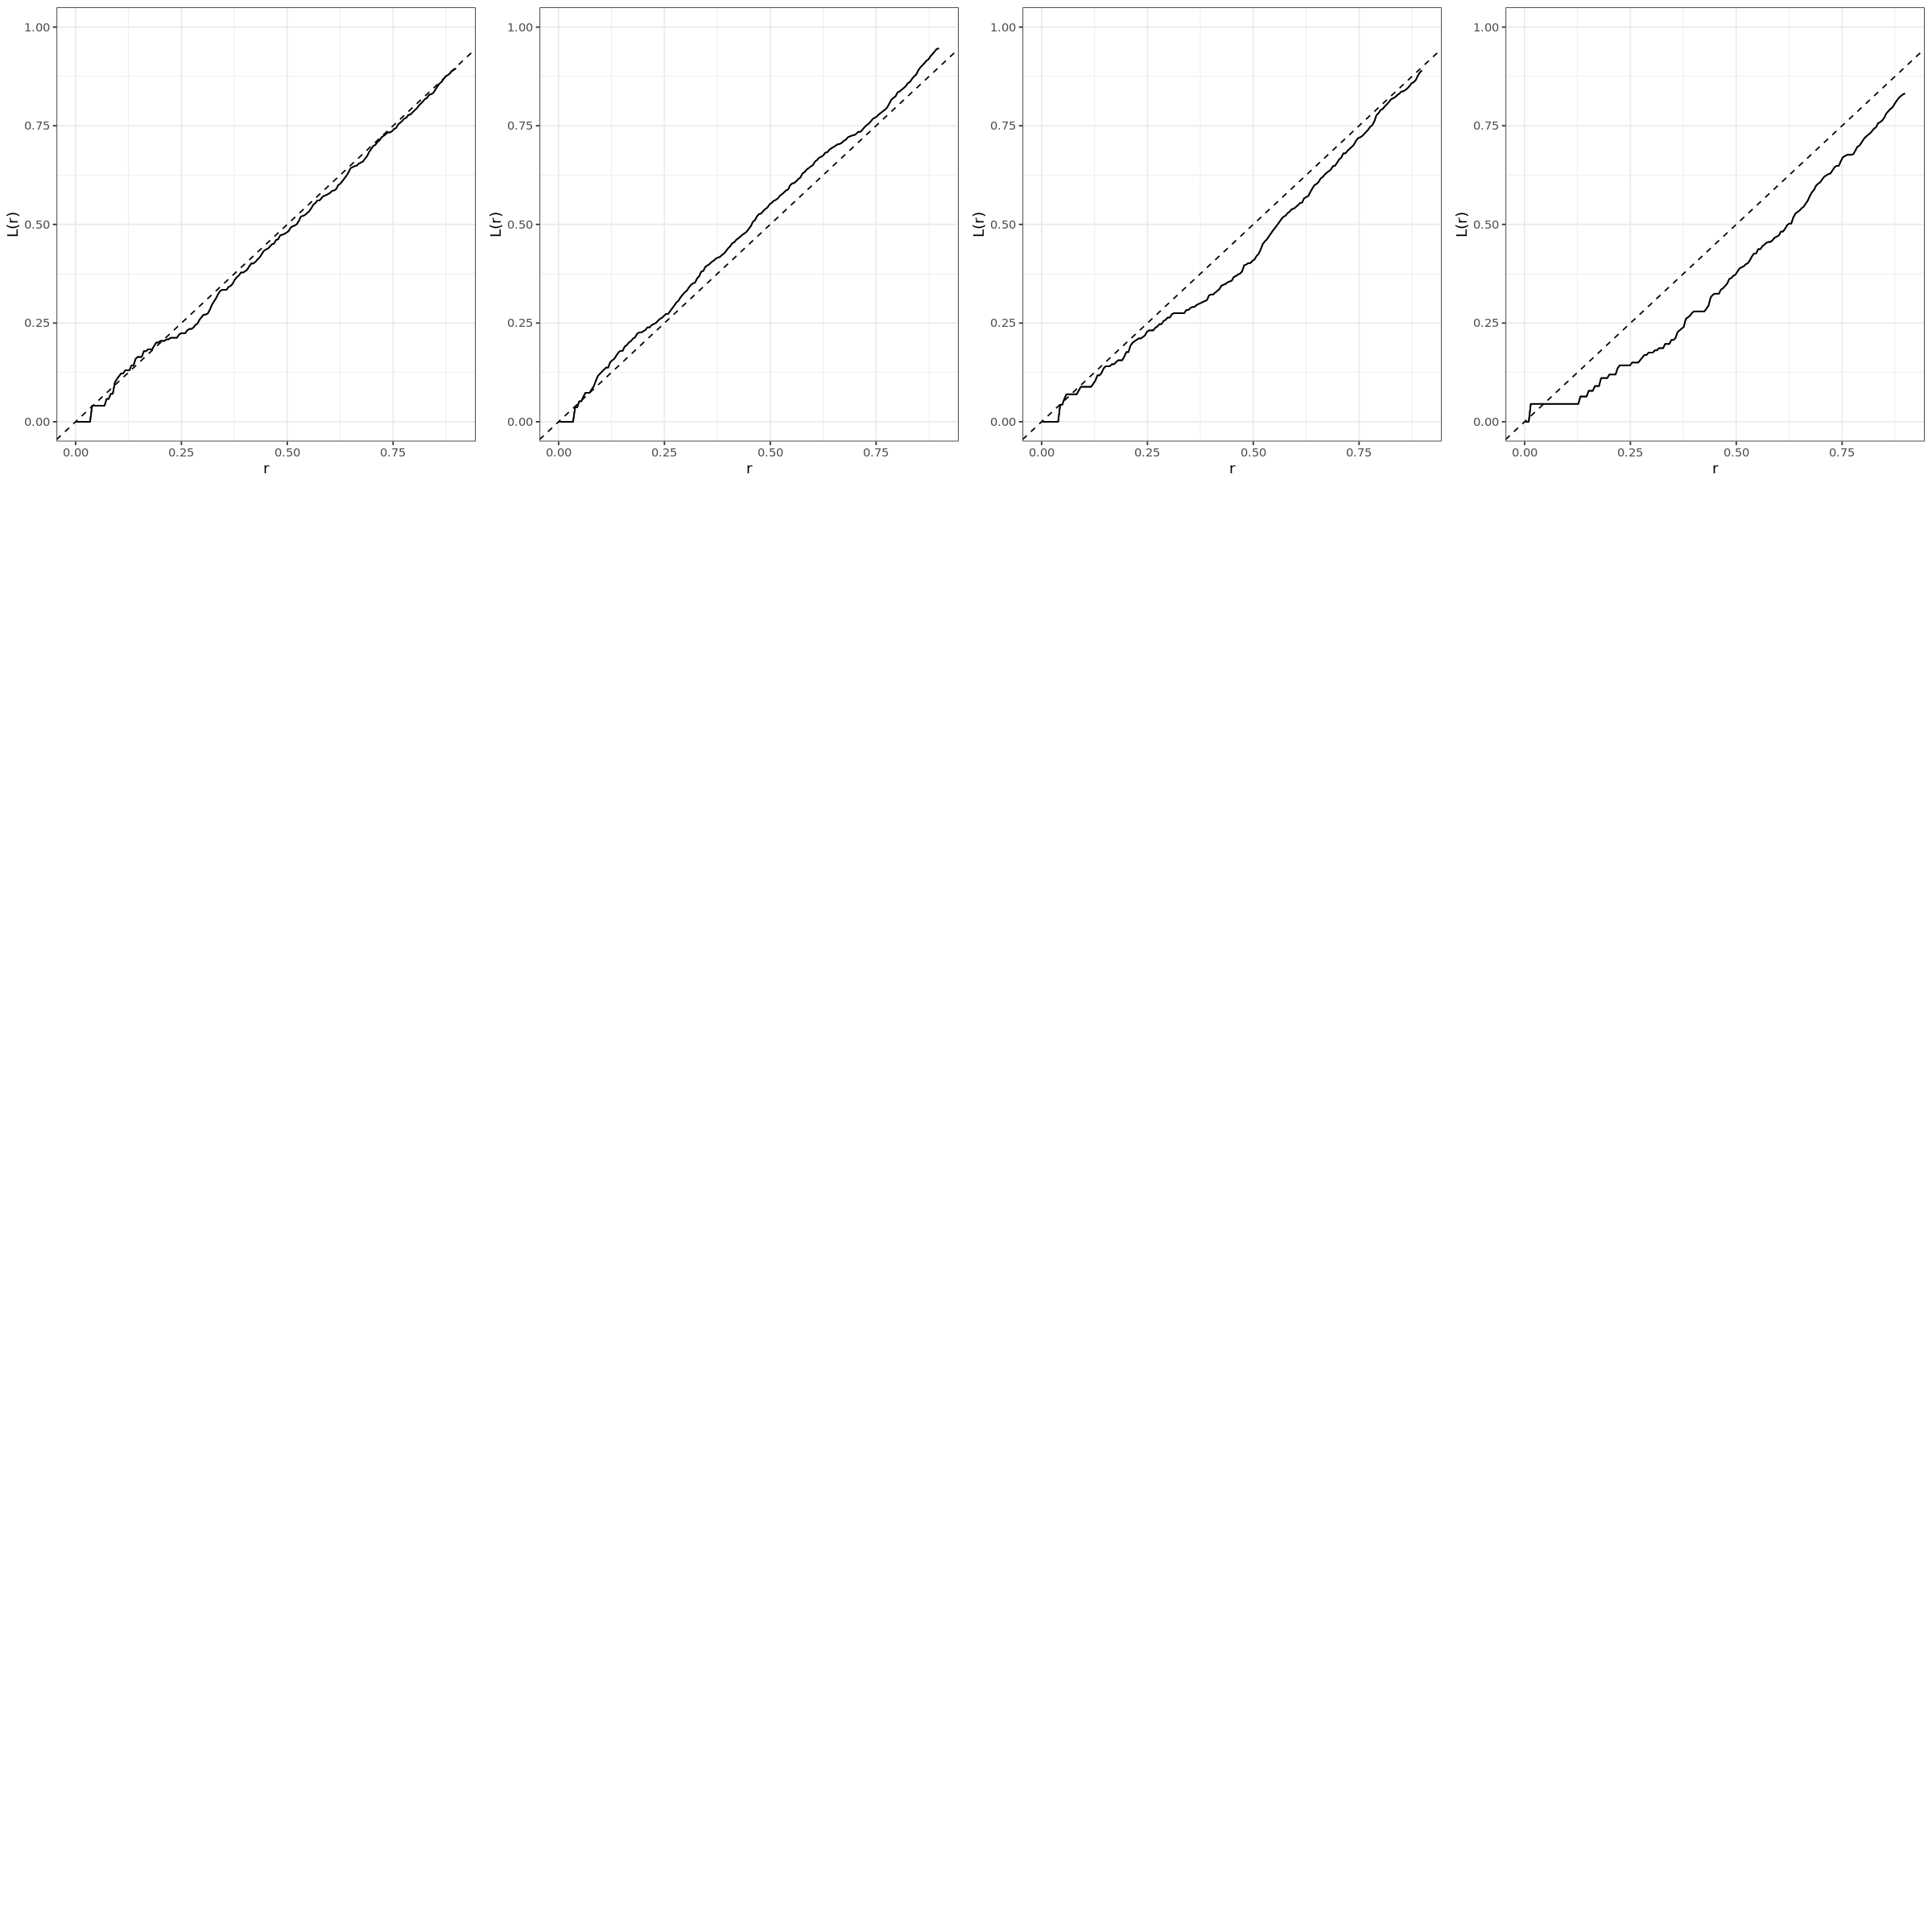

In [64]:
Lests <- lapply(samples, Lest)
plots <- lapply(Lests, 
                function(l) qplot(x = l$r, 
                                  y = l$iso,
                                  xlim = c(0, .9),
                                  ylim = c(0, 1.0),
                                  ylab = "L(r)",
                                  xlab = "r",
                                  geom = 'line'
                                 ) +
                geom_line() +
                geom_abline(intercept = 0, 
                            slope = 1,
                            linetype = "dashed"
                           ) +
                theme_bw())

options(warn=-1)
grid.arrange(plots[[1]], 
             plots[[2]], 
             plots[[3]], 
             plots[[4]],
             nrow = 4, ncol = 4)
options(warn=0)

## Simulations under Complete Spatial Randomness

First, we discuss the test statistics with complete spatial randomness as null hypothesis.

### Means and Variances of Test Statistics under the Null Model

To determine the means and variances of the test statistics under the null model, we compute the death times and accumulated life times for 10,000 independent samples of a Poisson point process.

In [14]:
seed <- 42
set.seed(seed)
nsim <- 1e4

ppps <- rpoispp(2, 
                win = win, 
                nsim = nsim)

Now, we collect the TDA-based statistics and Ripley's $L$-function into one list. Additionally, we include a linear combination of cluster-a

In [15]:
funs_sum <- list(function(X) mean((tda0(X)$trans[1:100])),
                 function(X) mean(tda1(X)$trans),
                 function(X) mean((tda0(X)$trans[1:100])) - 10 * mean(tda1(X)$trans),
                 function(X) mean(Lstat(X)$trans))

In [16]:
null_stats <- lapply(funs_sum, 
                    function(f) as.numeric(mclapply(ppps, 
                                         function(X) f(X),
                                                    mc.cores = 36))
                    )
null_means <- lapply(null_stats, mean)
null_sds <- lapply(null_stats, sd)

In [17]:
null_means
null_sds

[[1]]
[1] 0.6191307

[[2]]
[1] 0.02757224

[[3]]
[1] 0.3434083

[[4]]
[1] 0.2479299

[[1]]
[1] 0.04732301

[[2]]
[1] 0.00354182

[[3]]
[1] 0.05688698

[[4]]
[1] 0.01451172

Now, we compute the means and variances for the three statistics. For the loops and for Ripley's L-function, we can choose the entire relevant range of radii, so that $t_{\mathsf L} = t_{\mathsf{Ripley}} = 0.5$. For the clusters, it would be unreasonable, as for large values of the radius, we simply obtain the number of points in the observation window, which is not discriminative. Hence, we choose a smaller bound $t_{\mathsf C} = 0.1$.

### Test errors of Type I & II

Since the test statistics is asymptotically normal, knowledge of means and variances under the null model allows us to assess the test errors of type I and II.

In [13]:
p_val <- function(X,
                  stat,
                  null_mean,
                  null_sd){
    #' p-value for deviation test
    #'
    #' @param pp point pattern to be tested
    #' @param stat test statistics
    #' @param null_mean mean under the null model
    #' @param null_sd standard deviation under the null model
    z_val <- abs(stat(X) - null_mean) / null_sd
    2 * (1 - pnorm(z_val))
}

To analyze the type I and II errors, we draw 1,000 realizations from the null model and from the alternatives, respectively. Under the null model the rejection rates are close to the nominal 5\%-level, thereby illustrating that already for moderately large point patterns the approximation by the Gaussian limit is accurate.



Using the mean and variance from the null model, we now compute the test powers for the alternatives. Using the $L$-function based statistics $T_{\mathsf{Ripley}}$, in the Mat\'ern-cluster and Strauss process alternatives the null hypothesis is rejected in $92.6\%$ and $86.3\%$ of the cases. Using the TDA-based statistics $T_{\mathsf C}$ and $T_{\mathsf L}$ alone yields smaller rejection rates. However, the linear combination $T_{\mathsf C} - 10 T_{\mathsf L}$ leads to comparable rejection rates as the $L$-function.



Finally, the Baddeley-Silverman process showcases that for patterns with complex interactions, the $L$-function statistics may exhibit low power. In this setting, all three TDA-based statistics outperform the $L$-function
statistics. 

In [69]:
alpha <- .05
pps_list <- list(ppps_val, mcps, strs, basi, ginibs)

do.call(rbind.data.frame,
        lapply(seq(length(funs_sum)),
               function(i) sapply(pps_list[1:4],
                                  function(pp_list) sum(
                                      mclapply(pp_list, 
                                               function(pp) p_val(pp, 
                                                                  funs_sum[[i]],
                                                                  null_means[[i]], 
                                                                  null_sds[[i]]),
                                               mc.cores = 36
                                              ) < alpha) 
                                  )
               )
       )

c.55L..45L..47L..56L.,c.542L..614L..847L..910L.,c.556L..541L..905L..869L.,c.672L..836L..887L..603L.
<int>,<int>,<int>,<int>
55,542,556,672
45,614,541,836
47,847,905,887
56,910,869,603


## Simulations under a Cluster Process

So far, we have discussed how to use the cluster- and loop-based tests for testing the null hypothesis of complete spatial randomness. In the present section, we illustrate at the hand of a Matérn cluster process that it is possible to use for testing clustering or regularity of the point patterns. In other words, the null hypothesis is now a Mat\'ern cluster process

Similarly to the Poisson null model, in practice the intensity of the Matérn cluster process is not known but must be estimated from data. However, for the Matérn process the issue is more severe, since it is described by three parameter that all need to be estimated. For this purpose, we resort to the [minimum contrast method](https://www.crcpress.com/Statistical-Inference-and-Simulation-for-Spatial-Point-Processes/Moller-Waagepetersen/p/book/9781584882657).

In [11]:
seed <- 42
set.seed(seed)
nsim <- 1e3
nsim_nest <-1e2

ppps <- rpoispp(2, 
                win = win, 
                nsim = nsim)

mcps <- rMatClust(2, .5, 1, 
                  win = win, 
                  nsim = nsim) 

  In addition, now that the null model does not depend any longer on a single parameter, we cannot apply a simple rescaling to arrive at an intensity-adapted version of the estimators. Therefore, we need to resort to nested Monte Carlo simulations. That is, once we estimated the parameters of the Mat\'ern process, we determine the mean and variance of the test statistics based on $n_{\mathsf{nest}} = 100$ independent samples. Due to the complexity of the parameter estimation, we should expect substantial effects on the empirical results.



In the simulation study of 1,000 simulation runs, we use complete spatial randomness as alternative to the null hypothesis of clustering. First, all tests are conservative as the rejection rates under the null hypothesis are far below the nominal 5\%-level. This is particularly pronounced for $T_{\mathsf C}$ and $T_{\mathsf{Ripley}}$ where the null-hypothesis is never rejected. Regarding the type II error, although the linearly combined TDA-based test statistic $T_{\mathsf C} - 10 T_{\mathsf L}$ is outperformed by $T_{\mathsf{Ripley}}$, it still exhibits a reasonable rejection rate of $71.2\%$.

In [18]:
pps_list <- list(mcps, ppps)

set.seed(seed)

time <- Sys.time()

p_vals <- lapply(1:nsim,
       function(i){
    #estimate parameters
    pars <- as.numeric((matclust.estpcf(mcps[[i]])$modelpar))
           
    #simulate null model
    mcps_nest <-rMatClust(pars[1], pars[2], pars[3],
                          win = win,
                          nsim = nsim_nest)
           
    #compute mean and variance under null
    null_stats <- lapply(funs_sum, 
                        function(f) as.numeric(mclapply(mcps_nest, 
                                                      f,
                                                      mc.cores = 36
                                                     ))
                        )
    null_means <- lapply(null_stats, mean)
    null_sds <- lapply(null_stats, sd)
           
    #compute p-value
     do.call(cbind,
             lapply(pps_list,
                  function(pp_list)
                      sapply(1:4, 
                             function(j)
                                 p_val(pp_list[[i]],
                                       funs_sum[[j]],
                                       null_means[[j]],
                                       null_sds[[j]])
                             )
                    )
              )
           }
       )
Sys.time() - time

Warning message:
“Nelder-Mead simplex was degenerate”
Warning message:
“Nelder-Mead simplex was degenerate”


Time difference of 24.75055 mins

In [23]:
acc <- 0
alpha <- .05
for(i in 1:nsim)
    acc <- acc + (p_vals[[i]] < alpha)
acc

0,391
26,511
28,712
0,827


### Visualization

Finally, we visualize the average value of the statistics for the considered point processes.

The mean curves for the death times of clusters match up with the intuition about clustering and repulsion. For large radii, they all approach a common value, namely the expected number of points in the observation window. However, for the Matérn model, the slope is far steeper for small distances, caused by the merging of components of points within clusters. In contrast, for the Strauss process the slope is at first much smaller than in the Poisson model, thereby reflecting the repulsive nature of the Gibbs potential.

It is convenient to organize both the functional summary statistics in data frames.

In [46]:
tda_df <- function(pps, stat){
    #' return statistic in data frame
    #'
    #' @param pps point processes for statistics are computed
    #' @param stat summary statistic
    tda_list <- mclapply(pps,
                function(X) stat(X)$trans,
                mc.cores = 36
               )
    do.call('rbind', tda_list)
}

In [59]:
compare_df <- data.frame(
  t = t_vals0,
  ppp = colMeans(tda_df(ppps_val, tda0)),
  mcp = colMeans(tda_df(mcps, tda0)),
  str = colMeans(tda_df(strs, tda0)),
  bas = colMeans(tda_df(basi, tda0))
)

pl_1 <- ggplot(compare_df, aes(t)) +
  geom_line(aes(y = ppp, color = "a")) +
  geom_line(aes(y = mcp, color = "b")) +
  geom_line(aes(y = str, color = "c")) +
  geom_line(aes(y = bas, color = "d")) +
  scale_color_discrete(name = "Model", 
                       labels = c("Poisson", 
                                  "Matérn",
                                  "Strauss",
                                  "Badd.-Silv."
                                 )) +
  xlab('t') +
  ylab('number of deaths') + 
  theme_bw() +
  theme(text = element_text(size=font_size))

When comparing the shapes for the loop-based features, a radically different picture emerges. Here, the APF for the repulsive Strauss process lies above the accumulated life times of the null model. Although the average lifetime of the features in the Strauss process is smaller than in the Poisson model, there are substantially more births. Taken together, these competing effects still lead to a net increase of the accumulated life times in the Strauss model compared to the Poisson setting. 

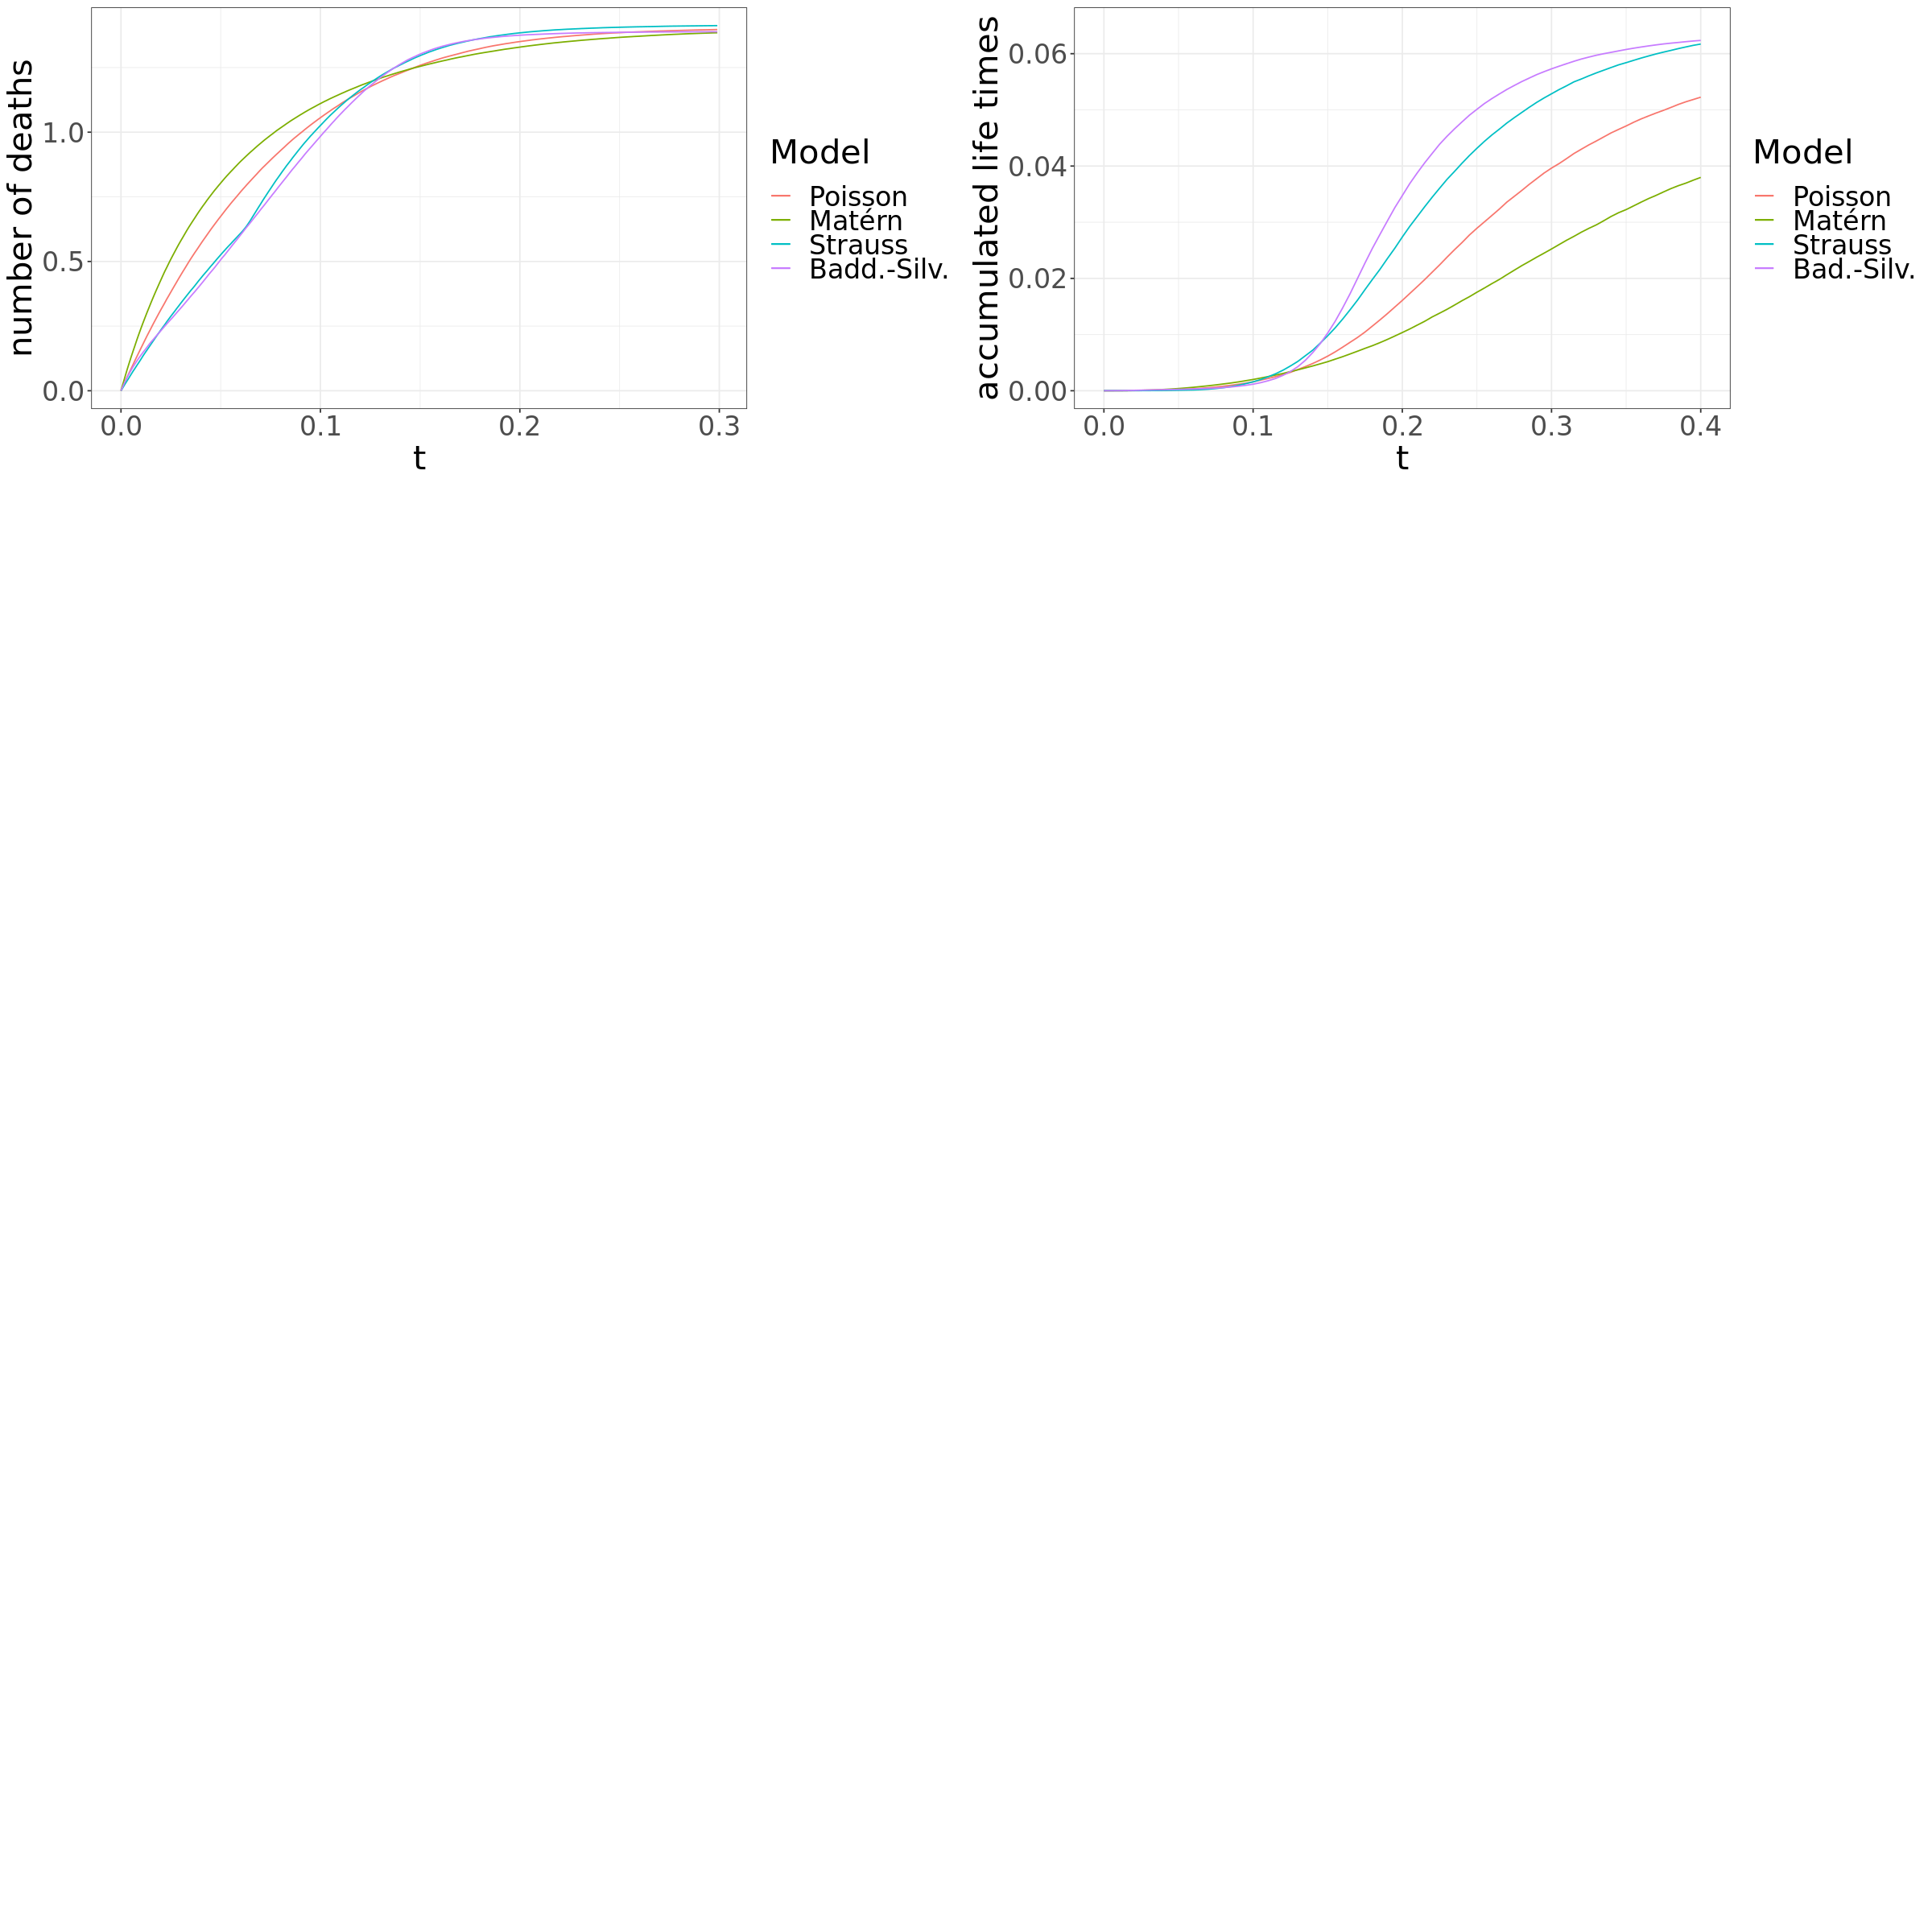

In [60]:
font_size <- 25

compare_df <- data.frame(
    t = t_vals1,
    ppp = colMeans(tda_df(ppps_val, tda1)),
    mcp = colMeans(tda_df(mcps, tda1)),
    str = colMeans(tda_df(strs, tda1)),
    bas = colMeans(tda_df(basi, tda1))
)
options(warn=-1)
pl_2 <- ggplot(compare_df, aes(t)) +
    geom_line(aes(y = ppp, color = "a")) +
    geom_line(aes(y = mcp, color = "b")) +
    geom_line(aes(y = str, color = "c")) +
    geom_line(aes(y = bas, color = "d")) +
    scale_color_discrete(name = "Model", 
                         labels = c("Poisson",
                                    "Matérn", 
                                    "Strauss",
                                    "Bad.-Silv."
                                   )) +
    xlim(c(0, .4)) +
    ylim(c(0,.065)) +
    xlab('t') +
    ylab('accumulated life times') + 
    theme_bw() +
    theme(text = element_text(size=font_size))
grid.arrange(pl_1, pl_2,
             nrow = 4, ncol = 2)
options(warn=0)

## Envelope Tests for Complete Spatial Randomness

Leveraging the functional CLT allowed us to deduce that the deviation statistics considered above is asymptotically normal. Hence, we could easily extract an estimate for the asymptotic variance under the null model via simulation.  A caveat of the above analysis is that the clustering and repulsion effects were very strong.

Recently, [global rank-envelope tests](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/rssb.12172) are becoming widely adopted, as they are both powerful and provide additional information as to why a null hypothesis is rejected. The global rank envelope tests are fundamentally Monte Carlo-based tests and therefore do not relate directly to the functional CLT. However, they also rely on a functional summary statistics as input. In most of the application cases in spatial statistics, one of the distance-based second-order functionals such as Ripley's K-function or L-function are used. In this section, we analyze the effect of replacing them by TDA-based statistics. 

Since envelope tests are typically able to detect very subtle changes from the null model, we consider now a parameter set-up, where both the Matérn cluster as well as the Strauss process are substantially more similar to the Poisson point process.

As a first step, we generate $s = 999$ realizations of the null model.

In [33]:
seed <- 43
set.seed(seed)

s <- 1e3 - 1

ppps_env <- rpoispp(2, 
                    win = win, 
                    nsim = s)

First, we extract the p-value from a functional test statistic.

In [80]:
p_val_env <- function(X, 
                      stat){
    #' p-value for deviation test
    #'
    #' @param X point pattern to be tested
    #' @param stat functional test statistic
    #' @param null_mean mean under the null model
    #' @param null_sd standard deviation under the null model
    
    env <- envelope(X, 
                fun = stat, 
                savefuns = TRUE, 
                verbose = FALSE,  
                correction = "translate",
                nsim = length(ppps_env),
                simulate = ppps_env)
    
    #p-value of rank-envelope
    test <- global_envelope_test(env, type="erl")
    attr(test, 'p')
}

We also introduce the linearly combined TDA-estimator.

In [83]:
tda01 <- function(X, 
                  r = 0,
                  correction = "translate"
                 ){
    #' Linearly combined TDA-estimator
    #'
    #' @param X point pattern
    #' @param r time point
    #' @param correction edge correction
    
    t0 <- tda0(X)
    t1 <- tda1(X)
    res <- t0$trans - 10 * t1$trans
    
    fv(data.frame(r = t0$r, 
                  trans = res), 
       valu = 'trans',
       labl = c('r', 'lab'),
       fname='Diag')
}

In [84]:
funs_sum <- lapply(list(tda0, tda1, tda01, Lest),
                   function(f)
                       function(X) p_val_env(X, f)
                       )

Now, we extract the p-values from the global envelope test. 

In [44]:
time <- Sys.time()
do.call(rbind.data.frame,
        lapply(funs_sum,
               function(f) sapply(pps_list[1:4],
                                  function(pp_list) sum(
                                      mclapply(pp_list, 
                                               f,
                                               mc.cores = 36
                                              ) < alpha) 
                                  )
))
Sys.time() - time

c.60L..33L..54L..47L.,c.690L..471L..750L..928L.,c.462L..247L..821L..976L.,c.655L..606L..928L..585L.
<int>,<int>,<int>,<int>
60,690,462,655
33,471,247,606
54,750,821,928
47,928,976,585


Time difference of 1.586437 hours